# Lab 06 - DOCUMENT CLUSTERING

Notebook version: 1.2402.0601

<br>
<br>

## Library Preparation

<br>

***If you use Google Colab, install sastrawi package***

In [1]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00


<br>

#### Import required library

In [2]:
import nltk
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from bs4 import BeautifulSoup

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

<br>

#### Download punctuation

<br>

***If you use Google Colab, download stopwords dan punkt package***

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<br>
<br>

## Helper Function

In [4]:
def tokenize_clean(text):

    #tokenisasi
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word
        in nltk.word_tokenize(sent)]

    #clean token from numeric and other character like puntuation
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    return filtered_tokens

In [5]:
stopwords = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(tokenized_text):

    cleaned_token = []
    for token in tokenized_text:
        if token not in stopwords:
            cleaned_token.append(token)

    return cleaned_token

In [6]:
#stem using Sastrawi StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [7]:
def stemming_text(tokenized_text):
    stems = []
    for token in tokenized_text:
        stems.append(stemmer.stem(token))

    return stems


In [8]:
def text_preprocessing(text):
    result_step1 = tokenize_clean(text)
    result_step2 = remove_stopwords(result_step1)
    result = stemming_text(result_step2)

    return result

#### text_preprocessing Function Test

In [9]:
dataset = 'Di daerah, alokasi anggaran Transfer ke Daerah dan Dana Desa (TKDD) ditetapkan sebesar Rp766,16 triliun pada APBN 2018'

In [10]:
text_prep_result = text_preprocessing(dataset)

In [11]:
len(text_prep_result)

12

In [13]:
print(text_prep_result)

['daerah', 'alokasi', 'anggar', 'transfer', 'daerah', 'dana', 'desa', 'tkdd', 'tetap', 'rp766 16', 'triliun', 'apbn']


<br>
<br>

<br>

## Dataset Collection

<br>

#### Download dataset from github

In [14]:
!mkdir -p dataset

In [15]:
!wget https://raw.githubusercontent.com/project303/dataset/master/Berita.txt -P dataset

--2024-02-06 17:59:06--  https://raw.githubusercontent.com/project303/dataset/master/Berita.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76212 (74K) [text/plain]
Saving to: ‘dataset/Berita.txt’

Berita.txt          100%[===================>]  74.43K  --.-KB/s    in 0.008s  

2024-02-06 17:59:07 (8.89 MB/s) - ‘dataset/Berita.txt’ saved [76212/76212]



In [16]:
!wget https://raw.githubusercontent.com/project303/dataset/master/Judul-Berita.txt -P dataset

--2024-02-06 17:59:10--  https://raw.githubusercontent.com/project303/dataset/master/Judul-Berita.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘dataset/Judul-Berita.txt’

Judul-Berita.txt    100%[===================>]   1.71K  --.-KB/s    in 0s      

2024-02-06 17:59:10 (13.7 MB/s) - ‘dataset/Judul-Berita.txt’ saved [1751/1751]



In [17]:
!ls dataset

Berita.txt  Judul-Berita.txt


In [18]:
! head dataset/Judul-Berita.txt

Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta
Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed
Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery
Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda
Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri
Klasemen Sementara Grup A Piala Dunia 2018
Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa
2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta
Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka'
Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras


## Data Preprocessing

<br>

### Step 01 - Read dataset

In [19]:
#load titles
article_titles = open('dataset/Judul-Berita.txt').read().split('\n')
len(article_titles)

31

In [20]:
article_titles[:10]

['Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta',
 'Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed',
 'Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery',
 'Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda',
 'Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri',
 'Klasemen Sementara Grup A Piala Dunia 2018',
 'Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa',
 '2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta',
 "Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka'",
 'Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras']

In [21]:
article_content = open('dataset/Berita.txt', encoding="utf8").read().split('BERHENTI DISINI')
len(article_content)

31

In [22]:
article_content[0]

'<html lang="en">\n\n    <head>\n    <title>Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta</title>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="robots" content="index, follow" />\n\n<body>\n<p>Jakarta, CNN Indonesia -- Agung Rahman, seorang nasabah Bank Mandiri di Karawang mengaku tiba-tiba kehilangan uang di rekening banknya. Akibat kejadian tersebut dia mengalami kerugian hampir Rp49 juta.</p>\n\n<p>Agung mengatakan sebelum kejadian tersebut saldo tabungan yang telah dihimpunnya selama setahun tersebut mencapai Rp49.667.000. Pada 10 Juni lalu, dia terakhir kali mengecek tabungan tersebut.</p>\n\n<p>Namun, sontak ia kaget. Pasalnya, sisa saldo di tabungannya tinggal Rp832.324.</p>\n\n<p>"Jadi, tiba- tiba hilang," katanya seperti dikutip dari Antara, Selasa (12/6).</p>\n\n<p>Agung kaget karena saldo tersebut berkurang banyak tanpa ia melakukan transaksi sama sekali. Ia mengklaim sudah berupaya mengecek ke Bank Mandiri.\n\nDari hasil p

<br>

### Step 02 - Cleanup dataset


Cleanup dataset from HTML tags using BeautifulSoup

In [23]:
article_clean = []
for text in article_content:
    text = BeautifulSoup(text, 'html.parser').getText()
    article_clean.append(text)

article_content = article_clean

In [24]:
article_content[0]

'\n\nNasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta\n\n\n\n\nJakarta, CNN Indonesia -- Agung Rahman, seorang nasabah Bank Mandiri di Karawang mengaku tiba-tiba kehilangan uang di rekening banknya. Akibat kejadian tersebut dia mengalami kerugian hampir Rp49 juta.\nAgung mengatakan sebelum kejadian tersebut saldo tabungan yang telah dihimpunnya selama setahun tersebut mencapai Rp49.667.000. Pada 10 Juni lalu, dia terakhir kali mengecek tabungan tersebut.\nNamun, sontak ia kaget. Pasalnya, sisa saldo di tabungannya tinggal Rp832.324.\n"Jadi, tiba- tiba hilang," katanya seperti dikutip dari Antara, Selasa (12/6).\nAgung kaget karena saldo tersebut berkurang banyak tanpa ia melakukan transaksi sama sekali. Ia mengklaim sudah berupaya mengecek ke Bank Mandiri.\n\nDari hasil pengecekan tersebut Bank Mandiri menyatakan bahwa berkurangnya saldo tabungan Agung terjadi akibat transaksi di rekeningnya.\n\n"Tapi ini janggal, karena saya merasa tidak pernah melakukan transaksi selama ini," kata

<br>
<br>

## Feature Extraction

<br>

### Step 03 - TF-IDF

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.1,
                                   max_features=200000,
                                   use_idf=True,
                                   tokenizer=text_preprocessing,
                                   ngram_range=(1,3))

In [26]:
get_ipython().magic(u'time tfidf_features = tfidf_vectorizer.fit_transform(article_content)')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 55s, sys: 347 ms, total: 1min 56s
Wall time: 1min 58s


In [27]:
print(tfidf_features.shape)

(31, 185)


In [28]:
bag_of_words = tfidf_vectorizer.get_feature_names_out()
len(bag_of_words)

185

In [29]:
bag_of_words[:10]

array(['acara', 'ajang', 'aksi', 'aku', 'alami', 'alias', 'amerika',
       'amerika serikat', 'anggota', 'angka'], dtype=object)

<br>
<br>

## Model Building

<br>

### Step 04 - K-Means Modelling

In [30]:
num_clusters = 3
model_km = KMeans(n_clusters=num_clusters, random_state=1000)

#train the model
get_ipython().magic(u'time model_km.fit(tfidf_features)')

CPU times: user 72.7 ms, sys: 7.97 ms, total: 80.7 ms
Wall time: 83.8 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=1000)

In [31]:
clusters = model_km.labels_.tolist()

<br>

### Step 05 - View The Result

In [32]:
article_no = []
for i in range(1, len(article_titles)+1):
    article_no.append(i)

In [33]:
article_cluster = { 'title': article_titles, 'no': article_no, 'article': article_content, 'cluster': clusters }
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(article_cluster, index = [clusters] , columns = ['no', 'title', 'cluster'])
df.sort_index()

,no,title,cluster
0,1,Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta,0
0,3,Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery,0
0,4,Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda,0
0,8,"2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta",0
0,9,Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka',0
0,10,Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras,0
0,14,Masih Banyak Perusahaan Tunggak Bayar THR Usai Lebaran,0
0,16,KPK Periksa Pejabat Agung Podomoro Terkait Kasus Bupati Rita,0
0,17,Tiga Bos First Travel Hadapi Tuntutan Jaksa Hari Ini,0
0,18,Aman Abdurrahman Pasrah Hadapi Vonis Kasus Terorisme,0


In [34]:
df['cluster'].value_counts()

0    13
2     9
1     9
Name: cluster, dtype: int64

Top words per cluster

In [35]:
df_bow = pd.DataFrame({'words': bag_of_words}, index = bag_of_words)

In [37]:
print("Top 10 words per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = model_km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % df_bow.loc[bag_of_words[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

    #print("Cluster %d titles:" % i, end='')
    #for title in df.loc[i]['title'].values.tolist():
    #   print(' %s,' % title, end='')
    #print() #add whitespace
    #print()

Top 10 words per cluster:
Cluster 0 words: b'duga', b'polisi', b'lapor', b'laku', b'pasal', b'korban', b'orang', b'anggota', b'juta', b'polri',

Cluster 1 words: b'menang', b'main', b'dunia', b'raih', b'tanding', b'poin', b'lawan', b'piala', b'piala', b'kalah',

Cluster 2 words: b'persen', b'dolar', b'triliun', b'lemah', b'bunga', b'saham', b'as', b'rupiah', b'lebaran', b'dagang',



<br>
<br>

<br>

## Cluster Visualization

### Step 07 - Visualization

In [38]:
similarity_distance = 1 - cosine_similarity(tfidf_features)
print(type(similarity_distance))
print(similarity_distance.shape)

<class 'numpy.ndarray'>
(31, 31)


In [39]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
get_ipython().magic(u'time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)')
print(pos.shape)

CPU times: user 68.9 ms, sys: 0 ns, total: 68.9 ms
Wall time: 85 ms
(31, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [40]:
print(pos)

[[ 0.25413122  0.51223011]
 [-0.23613322  0.52879565]
 [-0.00308587 -0.59982816]
 [-0.40128695 -0.52576641]
 [ 0.65287736  0.18976017]
 [ 0.6364058   0.2908526 ]
 [-0.32093799  0.46477204]
 [-0.69233396  0.07147765]
 [ 0.31463428 -0.65122535]
 [-0.33096694 -0.38079371]
 [ 0.53338019  0.38599006]
 [ 0.53867316 -0.09953887]
 [-0.19413949  0.48766394]
 [-0.61023662 -0.10821854]
 [-0.38036225  0.54328878]
 [-0.60275099 -0.32190826]
 [ 0.28228377 -0.44844099]
 [ 0.09639063 -0.35823282]
 [ 0.35199417  0.17958054]
 [ 0.18776819  0.02446694]
 [ 0.60569065 -0.34705637]
 [-0.14177192  0.62175305]
 [-0.40746443  0.24212272]
 [ 0.05001872  0.60615545]
 [-0.10553455 -0.69931494]
 [-0.12389097 -0.43446667]
 [-0.24220904 -0.5968999 ]
 [ 0.64576661 -0.19306028]
 [ 0.58969803  0.16045144]
 [-0.51418761  0.3148403 ]
 [-0.43241997  0.14054984]]


In [41]:
xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

<class 'numpy.ndarray'>


array([ 0.25413122, -0.23613322, -0.00308587, -0.40128695,  0.65287736,
        0.6364058 , -0.32093799, -0.69233396,  0.31463428, -0.33096694,
        0.53338019,  0.53867316, -0.19413949, -0.61023662, -0.38036225,
       -0.60275099,  0.28228377,  0.09639063,  0.35199417,  0.18776819,
        0.60569065, -0.14177192, -0.40746443,  0.05001872, -0.10553455,
       -0.12389097, -0.24220904,  0.64576661,  0.58969803, -0.51418761,
       -0.43241997])

In [49]:
#set up colors per clusters using a dict
cluster_colors = {0: '#00ff00', 1: '#d95f02', 2: '#7570b3'}

In [43]:
#set up cluster names using a dict
cluster_names = {0: 'Ekonomi',
                 1: 'Kriminal',
                 2: 'Olahraga'}

In [44]:
matplotlib inline

In [45]:
#some ipython magic to show the matplotlib plots inline
get_ipython().magic(u'matplotlib inline')

In [46]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=article_titles))

print(df[1:10])

          x         y  label  \
1 -0.236133  0.528796      2   
2 -0.003086 -0.599828      0   
3 -0.401287 -0.525766      0   
4  0.652877  0.189760      1   
5  0.636406  0.290853      1   
6 -0.320938  0.464772      2   
7 -0.692334  0.071478      0   
8  0.314634 -0.651225      0   
9 -0.330967 -0.380794      0   

                                                           title  
1  Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed  
2        Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery  
3  Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda  
4       Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri  
5                     Klasemen Sementara Grup A Piala Dunia 2018  
6         Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa  
7    2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta  
8     Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka'  
9  Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras  


In [47]:
# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)

{0: [0, 2, 3, 7, 8, 9, 13, 15, 16, 17, 24, 25, 26], 1: [4, 5, 10, 11, 18, 19, 20, 27, 28], 2: [1, 6, 12, 14, 21, 22, 23, 29, 30]}


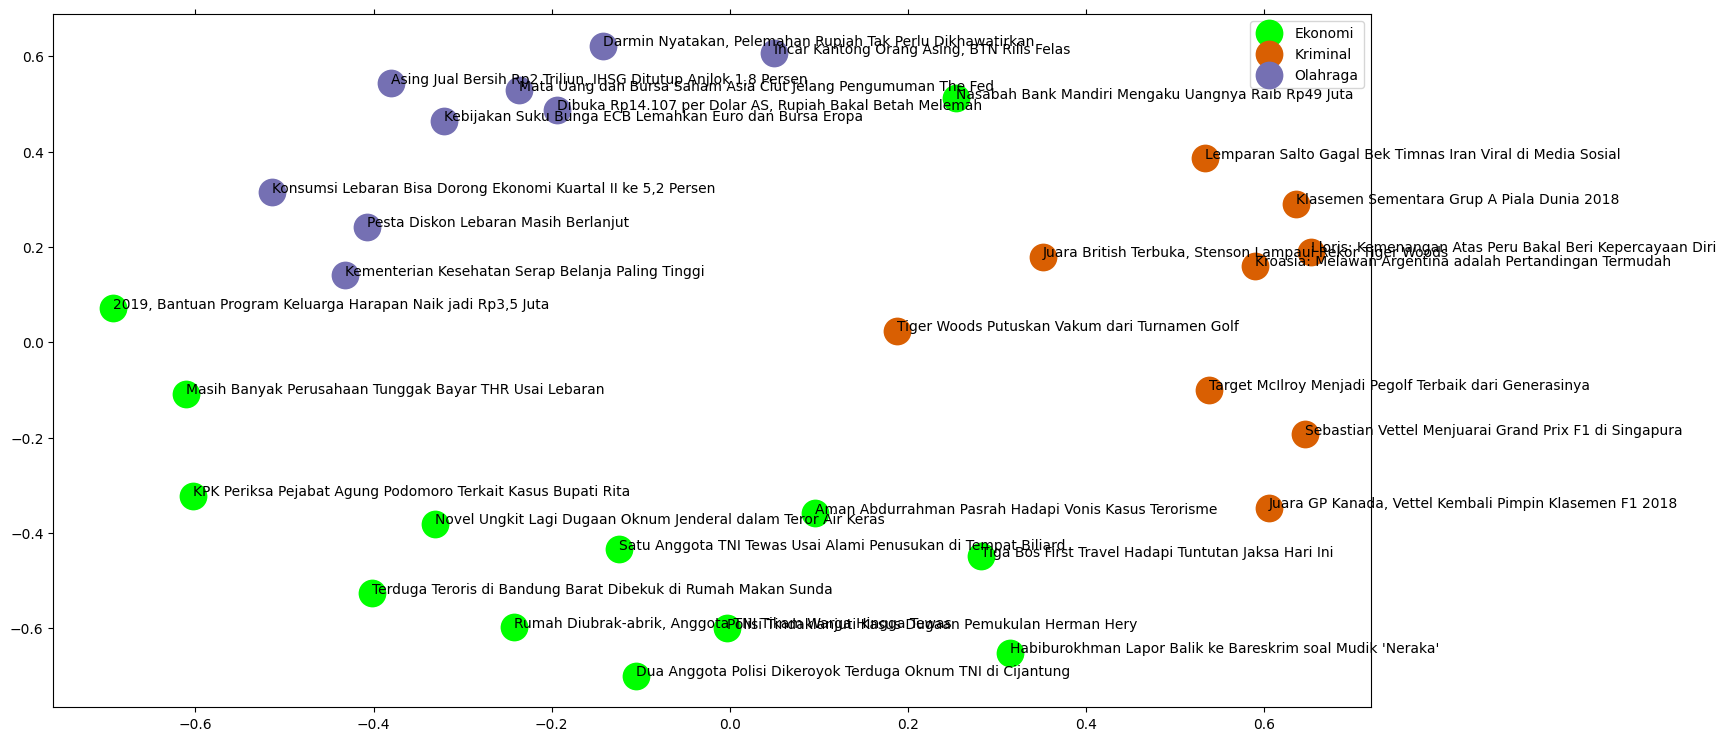

In [50]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
    #print("*******")
    #print("group name " + str(name))
    #print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20,
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=10)

plt.show()

In [ ]:
article_similarities = cosine_similarity(tfidf_features[0], tfidf_features).flatten()

In [ ]:
article_similarities

Simple example cosine similarities

In [51]:
search_terms = 'tomatoes is a fruit'
documents = ['cars drive on the road', 'tomatoes are actually fruit']

vectorizer = TfidfVectorizer(use_idf=True)
doc_vectors = vectorizer.fit_transform(documents)


In [52]:
search_vector = vectorizer.transform([search_terms])

cosine_similarities = cosine_similarity(search_vector, doc_vectors).flatten()
document_scores = [item.item() for item in cosine_similarities]

document_scores

[0.0, 0.7071067811865476]

<br>
<br>

## Revision History

Release: 1.2108.0101
*   Cleanup the code
*   Add cossine simimilarities

Release: 1.2402.0601
*   Tidy up the code
